In [36]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
mb_size = 64

transform = transforms.ToTensor()

trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=mb_size)

In [38]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()

In [39]:
imgs.shape

torch.Size([64, 1, 28, 28])

In [40]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

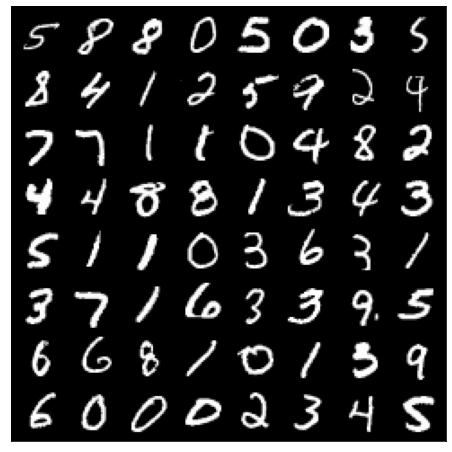

In [41]:
imshow(imgs)

In [42]:
Z_dim = 100
H_dim = 128
X_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, H_dim, X_dim)

device = 'cuda'

100 128 784


In [43]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Conv1d(Z_dim, H_dim, 4),
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            #nn.Conv1d(H_dim, X_dim, 4),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
          
    def forward(self, input):
        return self.model(input)

In [44]:
G = Gen().to(device)

In [45]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Conv1d(X_dim, H_dim, 4),
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, 1),
            #nn.Conv1d(H_dim, 1, 4),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

In [46]:
D = Dis().to(device)

In [47]:
print(G)
print(D)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [48]:
lr = 1e-3

g_opt = opt.Adam(G.parameters(), lr=lr)
d_opt = opt.Adam(D.parameters(), lr=lr)

Epoch:0,   G_loss:4.827975742471244,    D_loss:0.13040186593513578


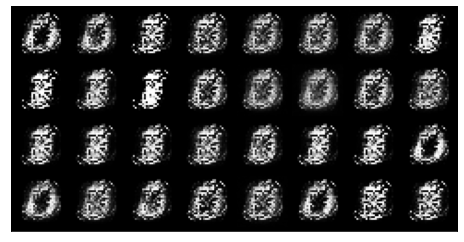

KeyboardInterrupt: ignored

In [49]:
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i, data in enumerate(trainLoader):
        X, _ = data
        X = X.view(X.size(0), -1).to(device)
        mb_size = X.size(0)
        
        one_labels = torch.ones(mb_size, 1).to(device)
        zero_labels = torch.zeros(mb_size, 1).to(device)
        
        z = torch.randn(mb_size, Z_dim).to(device)
        
        D_real = D(X)
        D_fake = D(G(z))
        
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_real_loss + D_fake_loss
        
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()
        
        z = torch.randn(mb_size, Z_dim).to(device)
        D_fake = D(G(z))
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    imshow(samples)
